In [1]:
# !if [ -f demo.tar ]; then rm demo.tar; fi
# !if [ -d test_data ]; then rm -rf test_data; fi
# !wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
# !tar -xf demo.tar

In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
import multiprocessing as mp
from sklearn.neighbors import NearestNeighbors


In [3]:
# data_path = "test_data/ridgecrest/"
data_path = "test_data/ncedc/"
# stations = pd.read_csv(os.path.join(data_path, "stations.csv"))
stations = pd.read_json(os.path.join(data_path, "stations.json"), orient="index")
stations["station_id"] = stations.index
# stations["depth_km"] = - stations["elevation_m"] / 1000

with open(os.path.join(data_path, "config.json")) as f:
    config = json.load(f)
stations = stations[(stations["longitude"] > config["minlongitude"]) & (stations["longitude"] < config["maxlongitude"]) & (stations["latitude"] > config["minlatitude"]) & (stations["latitude"] < config["maxlatitude"])]
stations.reset_index(drop=True, inplace=True)
stations.iloc[:3]

,network,station,location,instrument,component,sensitivity,latitude,longitude,elevation_m,depth_km,x_km,y_km,z_km,provider,station_id
0,AZ,KNW,,BH,12ENZ,"[839091000.0, 209773000.0, 839091000.0, 209773...",33.7141,-116.7119,1507.0,-1.507,258.718,-416.537,-1.507,NC,AZ.KNW..BH
1,AZ,KNW,,EH,12Z,"[31432900.0, 15716500.0, 31432900.0, 15716500....",33.7141,-116.7119,1507.0,-1.507,258.718,-416.537,-1.507,NC,AZ.KNW..EH
2,AZ,KNW,,HH,12ENZ,"[157649000.0, 39412300.0, 840484000.0, 2101210...",33.7141,-116.7119,1507.0,-1.507,258.718,-416.537,-1.507,NC,AZ.KNW..HH


In [4]:
## Automatic region; you can also specify a region
lon0 = stations["longitude"].median()
lat0 = stations["latitude"].median()

## projection to km
# proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0} +k=0.9996 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs")
proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0}  +units=km")
stations[["x_km", "y_km"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z_km"] = stations["elevation_m"].apply(lambda x: -x/1e3)

xmin = stations["x_km"].min()
xmax = stations["x_km"].max()
ymin = stations["y_km"].min()
ymax = stations["y_km"].max()
x0 = (xmin + xmax) / 2
y0 = (ymin + ymax) / 2

## set up the config; you can also specify the region manually
config = {}
config["xlim_km"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_km"] = (2 * ymin - y0, 2 * ymax - y0)
config["zlim_km"] = (stations["z_km"].min(), 20)
zmin = config["zlim_km"][0]
zmax = config["zlim_km"][1]

config["vel"] = {"P": 6.0, "S": 6.0/1.73}

config["bfgs_bounds"] = (
    (config["xlim_km"][0] - 1, config["xlim_km"][1] + 1),  # x
    (config["ylim_km"][0] - 1, config["ylim_km"][1] + 1),  # y
    # (config["zlim_km"][0], config["zlim_km"][1] + 1),  # z
    (0, config["zlim_km"][1] + 1),
    (None, None),  # t
)

mapping_phase_type_int = {"P": 0, "S": 1}
config["vel"] = {mapping_phase_type_int[k]: v for k, v in config["vel"].items()}


Text(0.5, 1.0, 'Stations')

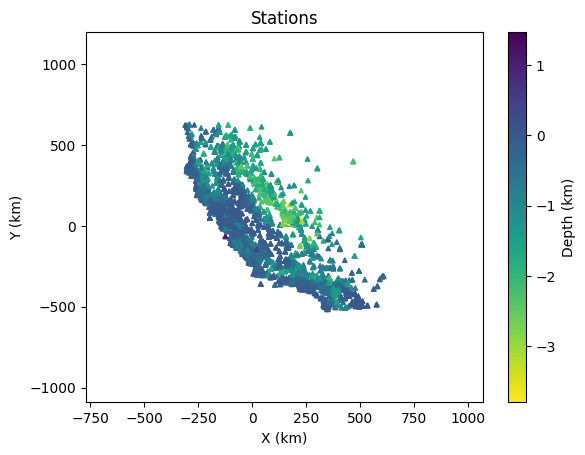

In [5]:
plt.figure()
plt.scatter(stations["x_km"], stations["y_km"], c=stations["depth_km"], cmap="viridis_r", s=10, marker="^")
plt.colorbar(label="Depth (km)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.xlim(config["xlim_km"])
plt.ylim(config["ylim_km"])
plt.title("Stations")

In [6]:
# data_path = "results/ridgecrest/"
data_path = "results/ncedc/"
picks = pd.read_csv(os.path.join(data_path, "gamma_picks.csv"), parse_dates=["phase_time"])
events = pd.read_csv(os.path.join(data_path, "gamma_events.csv"), parse_dates=["time"])
picks = picks[picks["station_id"].isin(stations["station_id"])]
picks.reset_index(drop=True, inplace=True)
events.reset_index(drop=True, inplace=True)

In [7]:
picks.iloc[:3]

,station_id,phase_time,phase_score,phase_type,phase_amplitude,begin_time,phase_index,dt,event_index,gamma_score
0,BK.AASB.00.HH,2023-01-01 18:35:49.170,0.476,P,6.782000e-06,2023-01-01T00:00:00.000,6694917,0.01,119,0.011214
1,BK.ADAM.00.HH,2023-01-01 18:32:33.250,0.488,P,3.604000e-07,2023-01-01T00:00:00.000,6675325,0.01,110,0.006685
2,BK.ADAM.00.HH,2023-01-01 18:52:58.650,0.520,P,2.249000e-07,2023-01-01T00:00:00.000,6797865,0.01,-1,-1.000000


In [8]:
events.iloc[:3]

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km),longitude,latitude,depth_km
0,2023-01-01 18:50:25.069,0.046,3.103,0.884,0.953,7.00,7,4,3,1,-179.263,-47.955,0.000,-121.515,37.051,0.000
1,2023-01-01 18:53:14.273,1.064,0.143,0.489,0.010,9.00,9,5,4,3,75.414,-268.635,11.825,-118.673,35.077,11.825
2,2023-01-01 18:39:00.297,1.105,4.993,0.491,1.124,50.31,40,20,20,15,-384.847,334.978,28.480,-124.033,40.430,28.480


In [9]:
from adloc.eikonal2d import eikonal_solve
from adloc.sacloc2d import ADLoc
from adloc import RANSACRegressor
import numpy as np

In [10]:
def init_eikonal2d(config):

    rlim = [0, np.sqrt((config["xlim_km"][1] - config["xlim_km"][0]) ** 2 + (config["ylim_km"][1] - config["ylim_km"][0]) ** 2)]
    zlim = config["zlim_km"]
    h = config["h"]

    rgrid = np.arange(rlim[0], rlim[1] + h, h)
    zgrid = np.arange(zlim[0], zlim[1] + h, h)
    nr = len(rgrid)
    nz = len(zgrid)

    vel = config["vel"]
    zz, vp, vs = vel["Z"], vel["P"], vel["S"]
    vp1d = np.interp(zgrid, zz, vp)
    vs1d = np.interp(zgrid, zz, vs)
    vp = np.tile(vp1d, (nr, 1))
    vs = np.tile(vs1d, (nr, 1))

    up = 1000 * np.ones((nr, nz))
    up[0, 0] = 0.0

    up = eikonal_solve(up, vp, h)
    grad_up = np.gradient(up, h, edge_order=2)
    up = up.ravel()
    grad_up = [x.ravel() for x in grad_up]

    us = 1000 * np.ones((nr, nz))
    us[0, 0] = 0.0

    us = eikonal_solve(us, vs, h)
    grad_us = np.gradient(us, h, edge_order=2)
    us = us.ravel()
    grad_us = [x.ravel() for x in grad_us]

    config.update(
        {
            "up": up,
            "us": us,
            "grad_up": grad_up,
            "grad_us": grad_us,
            "rgrid": rgrid,
            "zgrid": zgrid,
            "nr": nr,
            "nz": nz,
            "h": h
        }
    )

    return config

In [11]:
## Eikonal for 1D velocity model
zz = [0.0, 5.5, 16.0, 32.0]
vp = [5.5, 5.5,  6.7,  7.8]
vp_vs_ratio = 1.73
vs = [v / vp_vs_ratio for v in vp]
h = 0.3
vel = {"Z": zz, "P": vp, "S": vs}
config["eikonal"] = {"vel": vel, "h": h, "xlim_km": config["xlim_km"], "ylim_km": config["ylim_km"], "zlim_km": config["zlim_km"]}
config["eikonal"] = init_eikonal2d(config["eikonal"])


Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 4.149
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.789


In [12]:
# %%
stations.reset_index(drop=True, inplace=True)
stations["idx_sta"] = stations.index  # reindex in case the index does not start from 0 or is not continuous

events.reset_index(drop=True, inplace=True)
events["idx_eve"] = events.index  # reindex in case the index does not start from 0 or is not continuous

picks = picks.merge(events[["event_index", "idx_eve"]], on="event_index")

picks = picks.merge(stations[["station_id", "idx_sta"]], on="station_id")

In [13]:
# %% backup old events
events_old = events.copy()
events_old[["x_km", "y_km"]] = events_old.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
events_old["z_km"] = events["depth_km"]

In [14]:
## Location using ADLoc
# MIN_ADLOC_SCORE = 0.95
MIN_PICKS = 4
MIN_PICKS_RATIO = 0.2
MAX_RESIDUAL_S = 2.0 # The velocity model seems not very accurate, so I have to set a larger value
MIN_SCORE = 0.9

def is_model_valid(estimator, X, y):
    score = estimator.score(X, y)
    return score > MIN_SCORE

estimator = ADLoc(config, stations=stations[["x_km", "y_km", "z_km"]].values, eikonal=config["eikonal"])
event_init = np.array([[np.mean(config["xlim_km"]), np.mean(config["ylim_km"]), np.mean(config["zlim_km"]), 0.0]])

# events = []
# mask_idx = []
# error_idx = []
# picks_mask = []
# picks_error = []
# for event_index, picks_by_event in tqdm(picks.groupby("idx_eve")):
def calc_location(event_index, picks_by_event, estimator, events, mask_idx, picks_mask, error_idx, picks_error):

    X = picks_by_event.merge(
        stations[["x_km", "y_km", "z_km", "station_id"]],
        on="station_id",
    )
    event_init = np.array([[np.median(X["x_km"]), np.median(X["y_km"]), np.mean(config["zlim_km"]), 0.0]])
    
    t0 = X["phase_time"].min()
    X.rename(columns={"phase_type": "type", "phase_score": "score", "phase_time": "t_s"}, inplace=True)
    X["t_s"] = (X["t_s"] - t0).dt.total_seconds()
    X = X[["idx_sta", "type", "score", "t_s", ]]
    X["type"] = X["type"].apply(lambda x: mapping_phase_type_int[x])

    estimator.set_params(**{"events": event_init})
    ## Location using ADLoc
    # estimator.fit(X[["idx_sta", "type", "score"]].values, y=X["t_s"].values)
    # mask = np.ones(len(picks_by_event))

    ## Location using RANSAC
    reg = RANSACRegressor(
        estimator=estimator,
        random_state=0,
        min_samples=max(MIN_PICKS, int(MIN_PICKS_RATIO * len(picks_by_event))),
        residual_threshold=MAX_RESIDUAL_S,
        is_model_valid=is_model_valid,
    )
    try:
        reg.fit(X[["idx_sta", "type", "score"]].values, X["t_s"].values)
    except:
        return f"No valid model for event {event_index}"
    estimator = reg.estimator_
    mask = reg.inlier_mask_

    ## Predict travel time
    # score = estimator.score(X[["idx_sta", "type"]].values, y=X["t_s"].values)
    score = estimator.score(X[["idx_sta", "type", "score"]].values[mask], y=X["t_s"].values[mask])
    tt = estimator.predict(X[["idx_sta", "type"]].values)
    error_idx.extend(picks_by_event.index.values)
    picks_error.extend(X["t_s"].values - tt)

    # if np.sum(mask) > MIN_PICKS:
    mean_residual_s = np.mean(np.abs(X["t_s"].values - tt))
    x,y,z,t = estimator.events[0]
    events.append([event_index, x, y, z, t0 + pd.Timedelta(t, unit="s"), score, mean_residual_s, np.sum(mask)])
    mask_idx.extend(picks_by_event.index.values)
    picks_mask.extend(mask.astype(int))
    # else:
    #     mask_idx.extend(picks_by_event.index.values)
    #     picks_mask.extend(np.zeros(len(picks_by_event), dtype=int))


In [15]:
NCPU = mp.cpu_count()
with mp.Manager() as manager:
    mask_idx = manager.list()
    mask = manager.list()
    error_idx = manager.list()
    error = manager.list()
    locations = manager.list()
    pbar = tqdm(total=len(picks.groupby("idx_eve")))
    threads = []
    with mp.get_context("fork").Pool(NCPU) as pool:
        for event_index, picks_by_event in picks.groupby("idx_eve"):
            if len(picks_by_event) < MIN_PICKS:
                continue
            thread = pool.apply_async(calc_location, args=(event_index, picks_by_event, estimator, locations, mask_idx, mask, error_idx, error), callback=lambda x: pbar.update())
            threads.append(thread)
        for thread in threads:
            out = thread.get()
            if out is not None:
                print(out)
    mask_idx = list(mask_idx)
    mask = list(mask)
    error_idx = list(error_idx)
    error = list(error)
    locations = list(locations)
    pbar.close()


 90%|█████████ | 57/63 [00:06<00:00, 26.51it/s]

No valid model for event 22
No valid model for event 25
No valid model for event 30
No valid model for event 37


100%|██████████| 63/63 [00:07<00:00,  8.67it/s]


In [16]:
picks.loc[mask_idx, "mask"] = mask
picks.loc[error_idx, "residual_s"] = error
locations = pd.DataFrame(locations, columns=["idx_eve", "x_km", "y_km", "z_km", "time", "adloc_score", "adloc_residual_s", "num_picks"])
locations = locations.merge(events[["event_index", "idx_eve"]], on="idx_eve")
locations[["longitude", "latitude"]] = locations.apply(lambda x: pd.Series(proj(longitude=x["x_km"], latitude=x["y_km"], inverse=True)), axis=1)

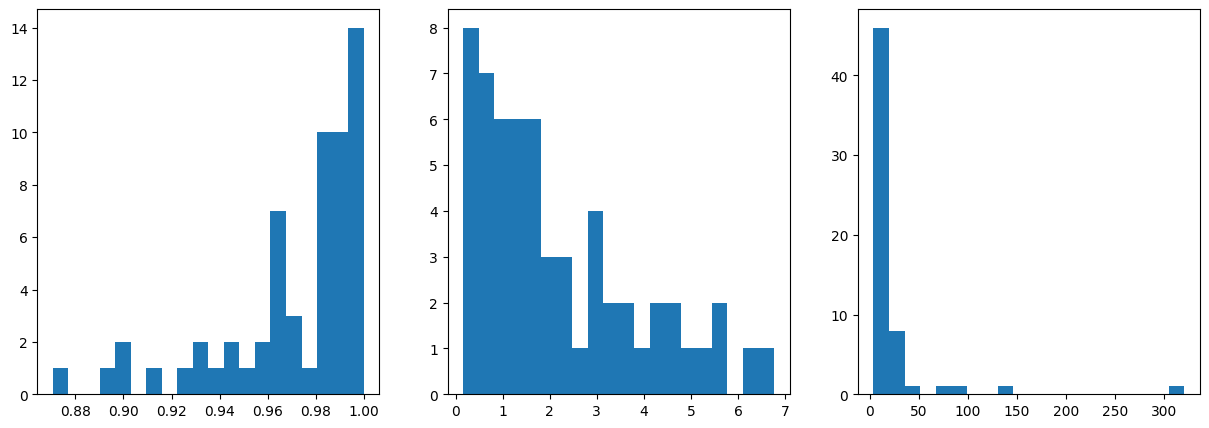

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(locations["adloc_score"], bins=20) 
plt.subplot(132)
plt.hist(locations["adloc_residual_s"], bins=20)
plt.subplot(133)
plt.hist(locations["num_picks"], bins=20)
plt.show()
# location = locations[locations["num_picks"] > 20]

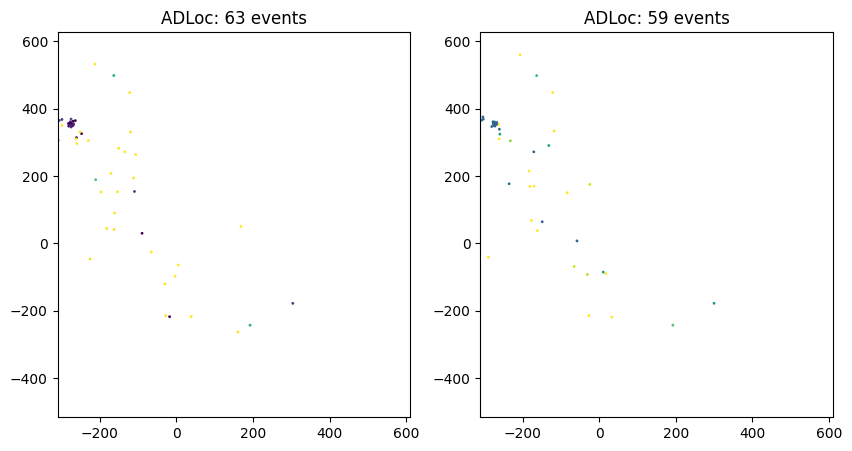

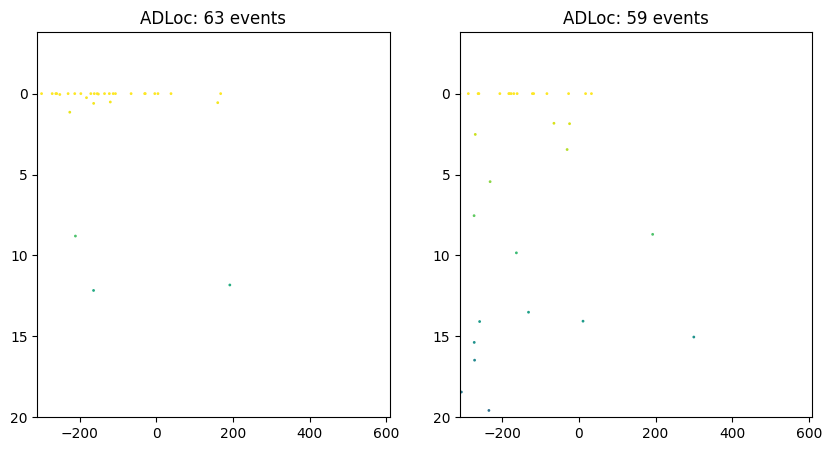

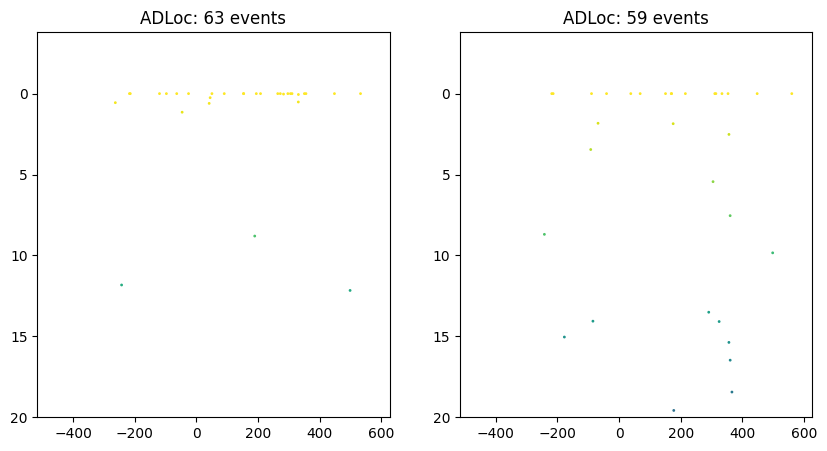

In [18]:
vmin = min(locations["z_km"].min(), events_old["depth_km"].min())
vmax = max(locations["z_km"].max(), events_old["depth_km"].max())
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["x_km"], events_old["y_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["x_km"], locations["y_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["x_km"], events_old["z_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["x_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(events_old["y_km"], events_old["z_km"], c=events_old["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([ymin, ymax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(events_old)} events")
plt.subplot(122)
plt.scatter(locations["y_km"], locations["z_km"], c=locations["z_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([ymin, ymax])
plt.ylim([zmax, zmin])
plt.title(f"ADLoc: {len(locations)} events")
plt.show()

In [19]:
lat0, lon0 = 40.409, -123.971
picks_ = picks.copy()
picks_ = picks_.merge(stations[["station_id", "latitude", "longitude"]], on="station_id")
picks_["dist_km"] = np.sqrt((picks_["latitude"] - lat0)**2 + (picks_["longitude"] - lon0)**2) * 111.32
events["dist_km"] = np.sqrt((events["latitude"] - lat0)**2 + (events["longitude"] - lon0)**2) * 111.32

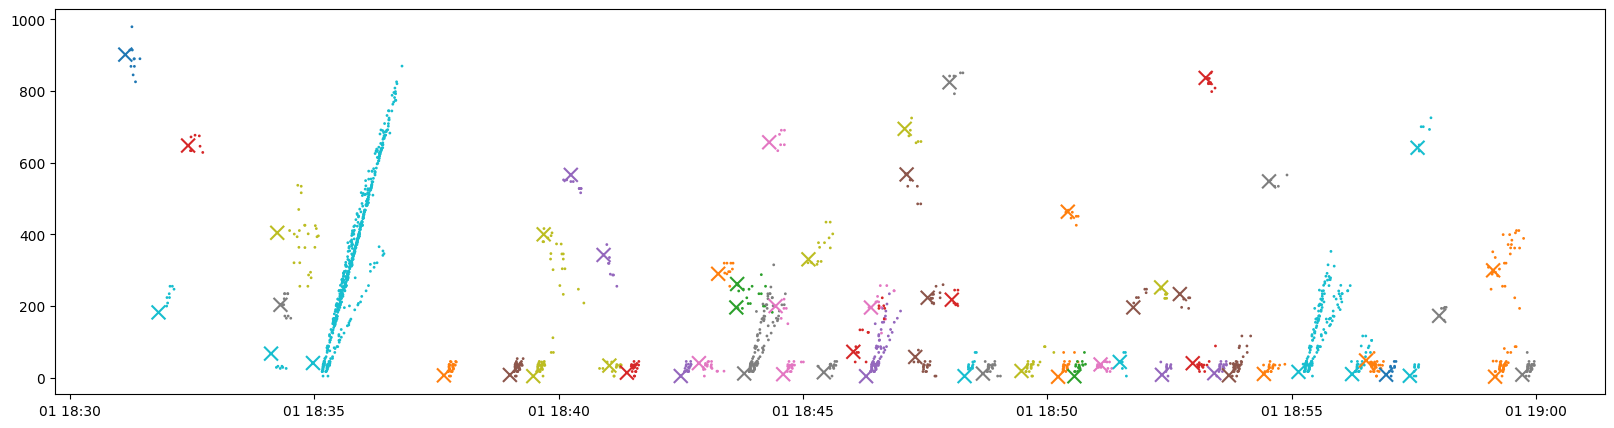

In [20]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["phase_time"], picks_["dist_km"], c=picks_["event_index"].apply(mapping_color), s=1)
plt.scatter(events["time"], events["dist_km"], c=events["event_index"].apply(mapping_color), s=100, marker="x")

In [21]:
lat0, lon0 = 40.409, -123.971
picks_ = picks.copy()
picks_ = picks_[picks_["mask"] == 1]
picks_ = picks_.merge(stations[["station_id", "latitude", "longitude"]], on="station_id")
picks_["dist_km"] = np.sqrt((picks_["latitude"] - lat0)**2 + (picks_["longitude"] - lon0)**2) * 111.32
locations["dist_km"] = np.sqrt((locations["latitude"] - lat0)**2 + (locations["longitude"] - lon0)**2) * 111.32

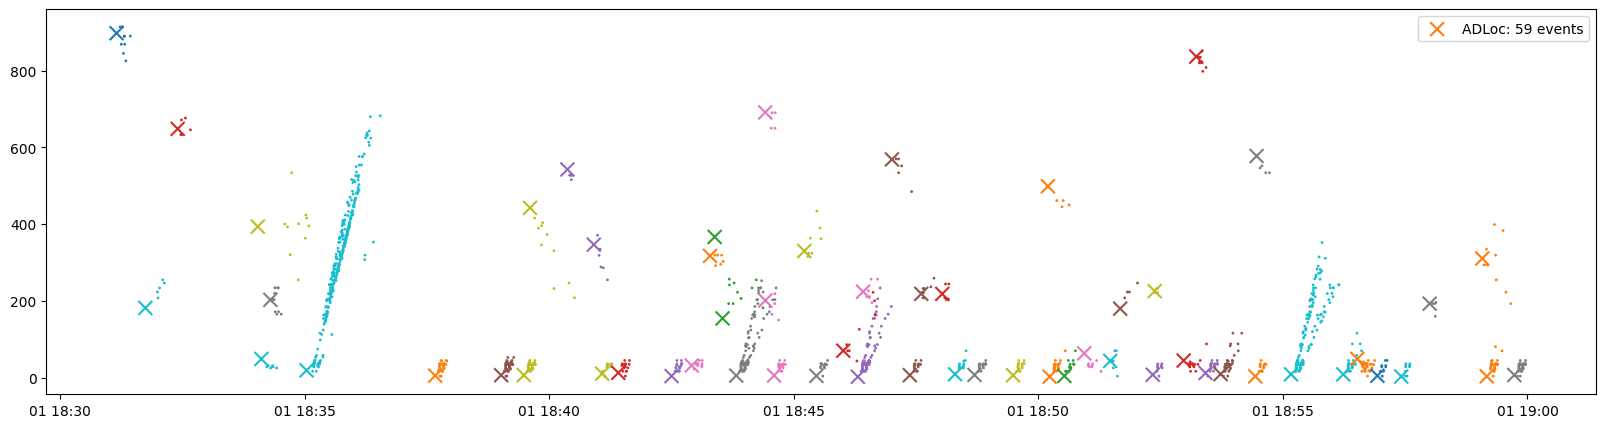

In [22]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["phase_time"], picks_["dist_km"], c=picks_["event_index"].apply(mapping_color), s=1)
plt.scatter(locations["time"], locations["dist_km"], c=locations["event_index"].apply(mapping_color), s=100, marker="x", label=f"ADLoc: {len(locations)} events")
plt.legend()

In [25]:
MIN_NEAREST_STATION_RATIO = 0.8

# %% filter out stations with no picks, like bad stations
stations = stations[stations["station_id"].isin(picks["station_id"].unique())]

neigh = NearestNeighbors(n_neighbors=min(len(stations), 10))
neigh.fit(stations[["longitude", "latitude"]].values)

# %%
picks_ = picks_.merge(events[["event_index", "longitude", "latitude"]], on="event_index", suffixes=("", "_event"))
picks_ = picks_.merge(stations[["station_id", "longitude", "latitude"]], on="station_id", suffixes=("", "_station"))

# %%
filtered_events = []
for i, event in tqdm(locations.iterrows(), total=len(locations)):
    sid = neigh.kneighbors([[event["longitude"], event["latitude"]]])[1][0]
    # picks_ = picks_[picks_["event_index"] == event["event_index"]]
    # longitude, latitude = picks_[["longitude", "latitude"]].mean().values
    # sid = neigh.kneighbors([[longitude, latitude]])[1][0]
    stations_neigh = stations.iloc[sid]["station_id"].values
    picks_neigh = picks_[picks_["station_id"].isin(stations_neigh)]
    stations_with_picks = picks_neigh["station_id"].unique()
    if len(stations_with_picks) / len(stations_neigh) > MIN_NEAREST_STATION_RATIO:
        filtered_events.append(event)

# %%
print(f"Events before filtering: {len(locations)}")
print(f"Events after filtering: {len(filtered_events)}")
filtered_events = pd.DataFrame(filtered_events)

100%|██████████| 59/59 [00:00<00:00, 829.36it/s]

Events before filtering: 59
Events after filtering: 47


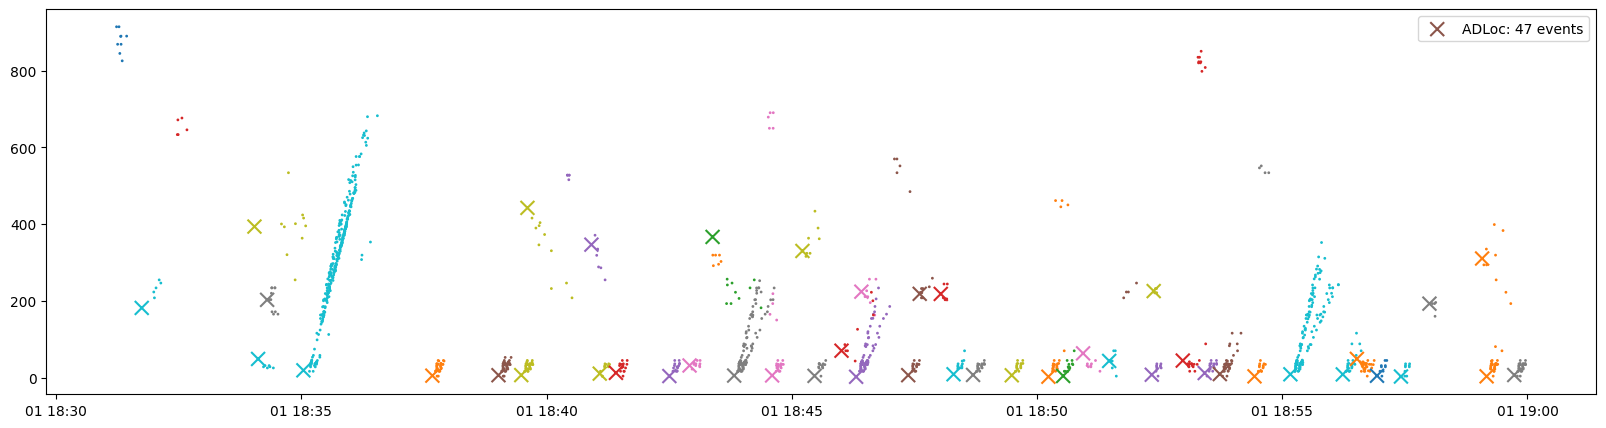

In [26]:
plt.figure(figsize=(20, 5))
mapping_color = lambda x: f"C{x}" if x >= 0 else "k"
plt.scatter(picks_["phase_time"], picks_["dist_km"], c=picks_["event_index"].apply(mapping_color), s=1)
plt.scatter(filtered_events["time"], filtered_events["dist_km"], c=filtered_events["event_index"].apply(mapping_color), s=100, marker="x", label=f"ADLoc: {len(filtered_events)} events")
plt.legend()